In [3]:
import sys

sys.path.append("..")

In [127]:
from calc_puzzle.solver import solve, is_unique
from calc_puzzle.types import Block, Problem
from calc_puzzle.visualize import visualize

import random
import numpy as np
import pulp
import copy

In [62]:
def create_random_answer_board(size, seed_size=5):
    all_numbers = set(range(0, size))
    vertical = [set([]) for _ in range(size)]
    horizontal = [set([]) for _ in range(size)]
    
    answer_board = None
    s = -1
    while s != 1:
        positions = [(x, y) for y in range(size) for x in range(size)]
        random.shuffle(positions)

        answer_board = -np.ones((size, size), dtype=np.int32)

        for x, y in positions[:seed_size]:
            l = list(all_numbers - (vertical[x] | horizontal[y]))
            if len(l) == 0:
                continue
            v = random.choice(list(all_numbers - (vertical[x] | horizontal[y])))

            answer_board[y, x] = v
            vertical[x].add(v)
            horizontal[y].add(v)

        answer_board[answer_board != -1] += 1
        prob = pulp.LpProblem("AnswerBoard", pulp.LpMinimize)
        prob += 0

        size = size
        numbers = range(1, size + 1)  # [1, 6)
        xs = range(1, size + 1)
        ys = range(1, size + 1)

        choices = pulp.LpVariable.dicts("Cell", (numbers, xs, ys), 0, 1, pulp.LpInteger)

        # 1つのマスに入る値は1つだけ

        for y in xs:
            for x in ys:
                prob += pulp.lpSum([choices[v][x][y] for v in numbers]) == 1

        for v in numbers:
            for y in ys:
                prob += pulp.lpSum([choices[v][x][y] for x in xs]) == 1

        for v in numbers:
            for x in xs:
                prob += pulp.lpSum([choices[v][x][y] for y in ys]) == 1

        for y in range(size):
            for x in range(size):
                if answer_board[y, x] != -1:
                    prob += choices[answer_board[y, x]][x + 1][y + 1] == 1

        s = prob.solve()
        answer_board = np.zeros((size, size), dtype=np.int32)
        for y in ys:
            for x in xs:
                for v in numbers:
                    if choices[v][x][y].value() == 1:
                        answer_board[y-1][x-1] = v
    return answer_board

In [102]:
answer_board = create_random_answer_board(5)

In [103]:
print(answer_board)

[[5 2 4 3 1]
 [2 1 5 4 3]
 [4 5 3 1 2]
 [3 4 1 2 5]
 [1 3 2 5 4]]


In [161]:
def md(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

In [284]:
def split_answer_board(num_centroids, answer_board):
    size = answer_board.shape[0]
    positions = [(x, y) for y in range(size) for x in range(size)]
    shuffled_positions = copy.deepcopy(positions)
    random.shuffle(shuffled_positions)
    centroids = shuffled_positions[:num_centroids]
    
    blocks = [[0, []]for _ in range(num_centroids)]

    for x, y in positions:
        r = np.array([md((x, y), c) for c in centroids]).argmin()
        b = blocks[r]
        b[0] += answer_board[y, x]
        b[1].append((x + 1, y + 1))
    blocks = list(map(lambda x: Block(*x), blocks))
    
    return blocks, centroids

In [285]:
while True:
    blocks,centroids = split_answer_board(num_centroids, answer_board)
    if is_unique(Problem(5, blocks)):
        break

In [286]:
blocks

[Block(sum_number=21, positions=[(2, 1), (3, 1), (2, 2), (3, 2), (2, 3), (2, 4)]),
 Block(sum_number=11, positions=[(4, 1), (5, 1), (4, 2), (5, 2)]),
 Block(sum_number=10, positions=[(3, 4), (4, 4), (3, 5), (4, 5)]),
 Block(sum_number=6, positions=[(3, 3), (4, 3), (5, 3)]),
 Block(sum_number=6, positions=[(1, 2), (1, 3)]),
 Block(sum_number=9, positions=[(5, 4), (5, 5)]),
 Block(sum_number=7, positions=[(1, 4), (1, 5), (2, 5)]),
 Block(sum_number=5, positions=[(1, 1)])]

In [287]:
centroids

[(1, 1), (3, 1), (3, 3), (3, 2), (0, 1), (4, 3), (0, 4), (0, 0)]

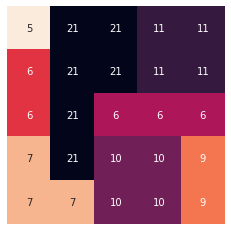

In [288]:
visualize(blocks, 5)

In [278]:
answer_board

array([[5, 2, 4, 3, 1],
       [2, 1, 5, 4, 3],
       [4, 5, 3, 1, 2],
       [3, 4, 1, 2, 5],
       [1, 3, 2, 5, 4]], dtype=int32)

In [259]:
is_unique(Problem(5, blocks))

True